# Realign Sensors Using Fieldtrip and Rot3Dfit

### This is a jupyter notebook to show the Yokogawa MEG user how to realign the MEG sensors to the correct co-ordinate system. This tutorial was made using a Matlab kernel for Jupyter.

### Requirements:
- Fieldtrip v20170501 or later
- parsePolhemus.m
- rot3dfit.m
- ft_transform_geometry_PFS_hacked.m

The final three scripts can be downloaded from: https://github.com/Macquarie-MEG-Research/coreg/tree/master/realign_MEG_sensors

In [2]:
%% Set file paths
dir_name = '.../realign_sens';
confile  = '.../2630_RS_PI160_2017_08_04_B1.con';
mrkfile  = '.../2630_RS_PI160_2017_08_04_ini.mrk';
elpfile  = '.../2630_RS_PI160_2017_08_04.elp';
hspfile  = '.../2630_RS_PI160_2017_08_04.hsp';

cd(dir_name);

In [3]:
% Add the path to Paul's parsePolhemus.m and rot3dfit funcions
addpath('.../scripts_mcq/alien')

In [4]:
% Read the grads from the con file
grad_con    = ft_read_sens(confile); %in cm, load grads
grad_con    = ft_convert_units(grad_con,'m');

% Read fidicials and headshape information
% I changed this so that data is no longer transformed to BESA co-ordinates
[shape]     = parsePolhemus(elpfile,hspfile); 
shape       = ft_convert_units(shape,'m');

% Read headshape and convert to cm
headshape            = ft_read_headshape(hspfile); headshape = ft_convert_units(headshape,'m');
headshape.fid.label  = shape.fid.label(1:3,:);

In [6]:
%% Read the mrk file and get the transformation matrix from MRK <--> ELP points
mrk             = ft_read_headshape(mrkfile);%,'format','yokogawa_mrk'); % Read mrk file
mrk             = ft_convert_units(mrk,'m');
markers         = mrk.fid.pos([2 3 1 4 5],:); %reorder mrk to match order in shape
[R,T,Yf,Err]    = rot3dfit(markers,shape.fid.pnt(4:end,:)); %calc rotation transform
meg2head_transm = [[R;T]'; 0 0 0 1]; %reorganise and make 4*4 transformation matrix

In [7]:
% Transform the sensors
grad_trans_MATLAB      = ft_transform_geometry_PFS_hacked(meg2head_transm,grad_con);
grad_trans_MATLAB.fid  = shape.fid; %add in the head information

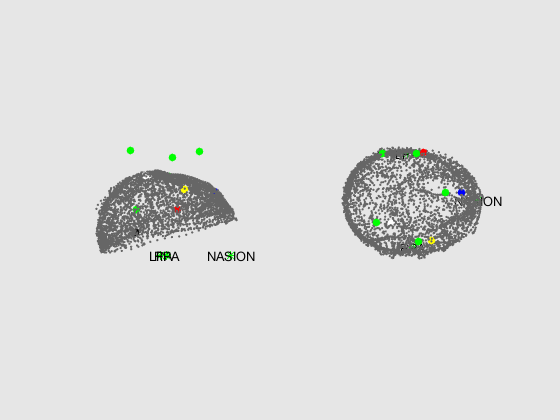

In [19]:
% Specify colors for markers
view_angle = [0,90];

figure('Color',[0.9 0.9 0.9],'InvertHardcopy','off');
for i = 1:2
    subplot(1,2,i);
    ft_plot_mesh(grad_trans_MATLAB.fid.pnt(4:end,:),'vertexcolor'...
    ,color_for_mrk,'vertexsize',20,'edgecolor','k'); hold on;
    ft_plot_mesh(markers,'vertexcolor','g','vertexsize',20,'edgecolor','k'); hold on;
    ft_plot_headshape(headshape,'vertexcolor',[0.4 0.4 0.4],'vertexsize',2);
    alpha 0.1; view(0,view_angle(i));
end


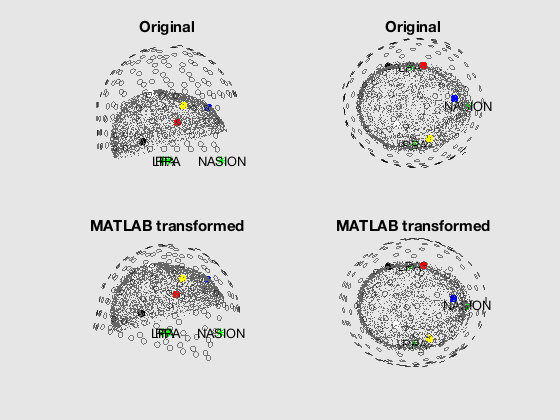

In [20]:
% Create figures for quality checking the transformation
figure('Color',[0.9 0.9 0.9],'InvertHardcopy','off');
for i = 1:2
    subplot(2,2,i);
    ft_plot_headshape(headshape,'vertexcolor',[0.4 0.4 0.4],'vertexsize',2); view(0,view_angle(i));
    ft_plot_mesh(grad_trans_MATLAB.fid.pnt(4:end,:),'vertexcolor',...
    color_for_mrk,'vertexsize',20,'edgecolor','k'); hold on;
    ft_plot_sens(grad_con,'edgealpha',0.5); 
    title('Original');
end

for i = 3:4
    subplot(2,2,i);
    ft_plot_headshape(headshape,'vertexcolor',[0.4 0.4 0.4],'vertexsize',2); view(0,view_angle(i-2));
    ft_plot_mesh(grad_trans_MATLAB.fid.pnt(4:end,:),'vertexcolor',color_for_mrk,...
    'vertexsize',20,'edgecolor','k'); hold on;
    ft_plot_sens(grad_trans_MATLAB,'edgealpha',0.5); 
    title('MATLAB transformed');
end

## But what about if there is a bad coil?

In [25]:
% Specify bad coil
bad_coil   = ['PFblue']; 

% Identify the bad coil
badcoilpos = find(ismember(shape.fid.label,bad_coil));

In [22]:
% Load in the marker information
marker_order    = [2 3 1 4 5];

mrk             = ft_read_headshape(mrkfile,'format','yokogawa_mrk');
mrk             = ft_convert_units(mrk,'m');
markers         = mrk.fid.pos(marker_order,:);%reorder mrk to match order in shape

In [23]:
% Now take out the bad marker when you realign
markers(badcoilpos-3,:) = [];
fids_2_use              = shape.fid.pnt(4:end,:); fids_2_use(badcoilpos-3,:) = [];
[R,T,Yf,Err]            = rot3dfit(markers,fids_2_use);%calc rotation transform
meg2head_transm         = [[R;T]'; 0 0 0 1];%reorganise and make 4*4 transformation matrix

grad_trans_MATLAB       = ft_transform_geometry_PFS_hacked(meg2head_transm,grad_con); %Use my hacked version of the ft function - accuracy checking removed not sure if this is good or not
grad_trans_MATLAB.fid   = shape.fid; %add in the head information

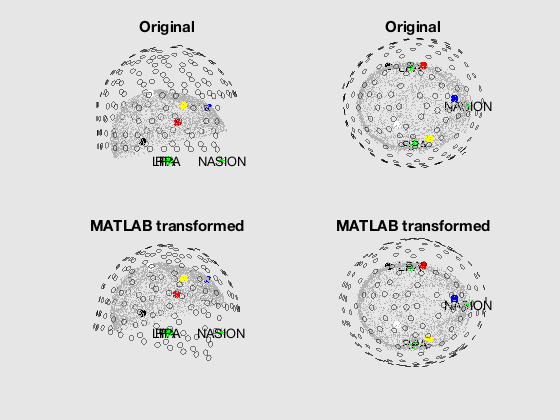

In [24]:
% View Realignment
color_for_mrk = [[1 0 0];[1 1 0];[0 0 1];[0 0 0];[1 1 1]];
view_angle    = [0,90];

figure('Color',[0.9 0.9 0.9],'InvertHardcopy','off');
for i = 1:2
    subplot(2,2,i);
    ft_plot_mesh(grad_trans_MATLAB.fid.pnt(4:end,:),'vertexcolor',...
    color_for_mrk,'vertexsize',20); hold on;
    ft_plot_sens(grad_con,'edgealpha',0.5); 
    ft_plot_headshape(headshape,'vertexcolor',[0.7 0.7 0.7],...
    'vertexsize',2); view(0,view_angle(i));
    title('Original');
end

for i = 3:4
    subplot(2,2,i);
    ft_plot_mesh(grad_trans_MATLAB.fid.pnt(4:end,:),'vertexcolor',...
    color_for_mrk,'vertexsize',20); hold on;
    ft_plot_sens(grad_trans_MATLAB,'edgealpha',0.5); 
    ft_plot_headshape(headshape,'vertexcolor',[0.7 0.7 0.7],...
    'vertexsize',2); view(0,view_angle(i-2));
    title('MATLAB transformed');
end